<a href="https://colab.research.google.com/github/revian2119/CNN-classifier-for-text/blob/main/VM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [45]:
data = pd.read_excel("data2.xlsx")
data.head()

,Classes,Sentences
0,2,"Yok, sağ olasın."
1,2,"Yani, yaptığı bütün o korkunç şeylerden sonra ..."
2,1,At tam gözden kaybolmadan önce aniden dönerek ...
3,1,Patika da yoldan sağa doğru ayrılıp yaşlı bir ...
4,1,Sağa sola sallanıyordu.


In [46]:
data['Classes'].value_counts()

1    915
2    585
Name: Classes, dtype: int64

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [48]:
# build train and test datasets
sentences = data['Sentences'].values
classes = data['Classes'].values

train_sentences = sentences[:1050]
train_classes = classes[:1050]

test_sentences = sentences[1050:]
test_classes = classes[1050:]

In [49]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [50]:
%%time

norm_train_sentences = pre_process_corpus(train_sentences)
norm_test_sentences = pre_process_corpus(test_sentences)


100%|██████████| 450/450 [00:00<00:00, 6820.23it/s]

CPU times: user 207 ms, sys: 15.1 ms, total: 222 ms
Wall time: 227 ms


In [51]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_sentences)
t.word_index['<PAD>'] = 0

In [52]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dusunmuyordu', 5004), ('<PAD>', 0), 1)

In [53]:
train_sequences = t.texts_to_sequences(train_sentences)
test_sequences = t.texts_to_sequences(test_sentences)

In [54]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=5005
Number of Documents=1050


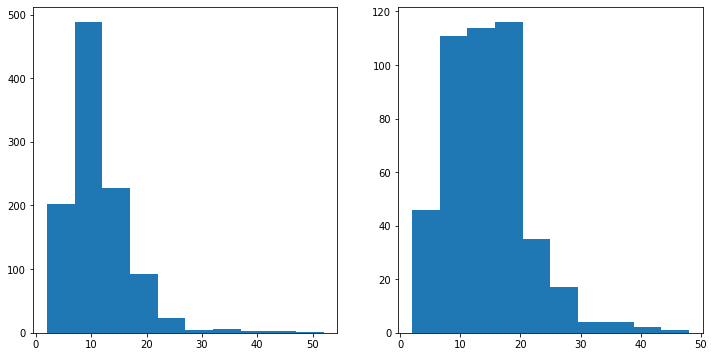

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [56]:
MAX_SEQUENCE_LENGTH = 100

In [57]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((1050, 100), (450, 100))

In [58]:
le = LabelEncoder()
num_classes=2 # class 2 -> 1, class 1 -> 0

In [59]:
y_train = le.fit_transform(train_classes)
y_test = le.transform(test_classes)

In [60]:
VOCAB_SIZE = len(t.word_index)

In [61]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [62]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          1501500   
                                                                 
 conv1d_6 (Conv1D)           (None, 100, 128)          153728    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 50, 128)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 50, 64)            32832     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 25, 32)          

In [63]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
8/8 [==============================] - 4s 388ms/step - loss: 0.6927 - accuracy: 0.5333 - val_loss: 0.6628 - val_accuracy: 0.6381
Epoch 2/2
8/8 [==============================] - 4s 555ms/step - loss: 0.6677 - accuracy: 0.6032 - val_loss: 0.5993 - val_accuracy: 0.6762


In [64]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("F1 Score: %.2f%%" % (scores[0]*100))

15/15 [==============================] - 1s 45ms/step - loss: 0.5702 - accuracy: 0.7000
Accuracy: 70.00%
F1 Score: 57.02%


In [65]:
predictions = model.predict(X_test)
predictions[:10]
mean = np.mean(predictions)
print(mean)


0.37356994


In [66]:
predictions = ['2' if item >= 0.398 else '1' for item in predictions]
predictions[:25]

['1',
 '2',
 '2',
 '1',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '1',
 '1',
 '1',
 '1',
 '2']

In [68]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['class 1', 'class 2']
print(classification_report(test_classes.astype(str), predictions))
pd.DataFrame(confusion_matrix(test_classes.astype(str), predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           1       0.84      0.78      0.81       304
           2       0.60      0.70      0.65       146

    accuracy                           0.75       450
   macro avg       0.72      0.74      0.73       450
weighted avg       0.76      0.75      0.76       450



,class 1,class 2
class 1,236,68
class 2,44,102
